In [1]:
#!/usr/bin/env python
# coding: utf-8


#!conda activate huggingface_env
#conda info
#ls
# import packages
import sys
import pandas as pd
import numpy as np
import sklearn
from matplotlib import pyplot as plt
import re
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig 
from transformers import GPT2Tokenizer, TrainingArguments, Trainer, GPT2LMHeadModel, AutoTokenizer, GPTJForCausalLM, GPTJConfig, GPTNeoXForCausalLM, GPTNeoXTokenizerFast, AutoModelForCausalLM, AutoConfig
from sklearn.model_selection import train_test_split
from tabulate import tabulate
from tqdm import trange
import random
from ml_things import plot_dict, plot_confusion_matrix, fix_text
import os
os.environ['WANDB_DISABLED'] = 'true'
pd.options.display.max_colwidth = 1000

from pathlib import Path    
import os


import torch
import torch.nn as nn
import torch.nn.functional as F


cwd = os.getcwd()
from huggingface_hub import login
pd.options.display.max_colwidth = 1000
access_token = os.getenv("HUGFACE_TOKEN")
login(token=access_token)


/cfs/earth/scratch/stdg/.conda/envs/litparrot2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /cfs/earth/scratch/stdg/.conda/envs/litparrot2/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cuda116.so
CUDA SETUP: CUDA runtime path found: /cfs/earth/scratch/stdg/.conda/envs/litparrot2/lib/libcudart.so.12.0
CUDA SETUP: Highest compute capability among GPUs detected: 8.0
CUDA SETUP: Detected CUDA version 116
CUDA SETUP: Loading binary /cfs/earth/scratch/stdg/.conda/envs/litparrot2/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cuda116.so...


/cfs/earth/scratch/stdg/.conda/envs/litparrot2/lib/python3.10/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: Found duplicate ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] files: {PosixPath('/cfs/earth/scratch/stdg/.conda/envs/litparrot2/lib/libcudart.so.12.0'), PosixPath('/cfs/earth/scratch/stdg/.conda/envs/litparrot2/lib/libcudart.so'), PosixPath('/cfs/earth/scratch/stdg/.conda/envs/litparrot2/lib/libcudart.so.11.0')}.. We'll flip a coin and try one of these, in order to fail forward.
Either way, this might cause trouble in the future:
If you get `CUDA error: invalid device function` errors, the above might be the cause and the solution is to make sure only one ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] in the paths that we search based on your env.
  warn(msg)


Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /cfs/earth/scratch/stdg/.cache/huggingface/token
Login successful


In [2]:

train_path = os.path.expanduser('..')
test_path = os.path.expanduser('..')

#read test_data_en.csv to a dataframe test_data
# test_data = pd.read_csv(test_path, sep=',', encoding='utf-8')
#reat the test_data.xlsx to a dataframe test_data
test_data = pd.read_excel(test_path,sheet_name='Sheet1')
print(test_data.columns)
# sys.exit()
#drop columns "Unnamed: 0", "sentence"
test_data=test_data.drop(['Unnamed: 0',], axis=1)
#rename column "sentence_en" to "sentence"
# test_data=test_data.rename(columns={'sentence_en': 'sentence'})
#read train_data_en.csv to a dataframe train_data
train_data = pd.read_csv(train_path, sep=',', encoding='utf-8')
#change the label column to int
train_data['label'] = train_data['label'].astype(int)
#drop columns "Unnamed: 0", "sentence"
# train_data=train_data.drop(['Unnamed: 0', 'sentence'], axis=1)
#rename column "sentence_en" to "sentence"
# train_data=train_data.rename(columns={'sentence_en': 'sentence'})
#print column names of train_data
print(train_data.columns)
#print count values of label column in train_data
print(pd.crosstab(index=train_data['label'], columns='count'))
#print column names of test_data
print(test_data.columns)
#print count values of label column in test_data
print(pd.crosstab(index=test_data['label'], columns='count'))
#print first 10 rows of test_data sentence column
# print(test_data['sentence'].head(10))
#print first 10 rows of train_data sentence column
# print(train_data['sentence'].head(10))



#drop na values
train_data=train_data.dropna()
test_data=test_data.dropna()




from sklearn.utils import shuffle

gewalt_string = [ "Klient hat Gewalt erfahren", "Klient hat häusliche Gewalt erlebt", "Klient hat Gewalt ausgeübt",  "Klient hat sexuelle Gewalt erlebt", "Klient hat keine Gewalt erlebt"]

# # Model Implementierung
from transformers import AutoModelForSequenceClassification
import torch
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding, AutoConfig
import aiohttp
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# device = torch.device("cpu") if torch.cuda.is_available() else torch.device("cpu")
CUDA_LAUNCH_BLOCKING=1
print(device)

from datasets import load_dataset

import aiohttp

# model_name = "dragstoll/gewalt_klassen_alle_xln_roberta_xl_20231017_2209"
model_name = "dragstoll/gewalt_klassen_alle_xln_roberta_xl_20231020_1832"
#print model name
print("Model name:", model_name)


Index(['Unnamed: 0', 'label', 'sentence'], dtype='object')
Index(['label', 'sentence'], dtype='object')
col_0  count
label       
0        678
1        912
2        772
3        224
4       1233
Index(['label', 'sentence'], dtype='object')
col_0  count
label       
0         78
1         73
2         95
3         81
4        197
cuda
Model name: dragstoll/gewalt_klassen_alle_xln_roberta_xl_20231020_1832


In [3]:

# model_name_clean=model_name.replace("/","_")
# #create a variable with date and time stamp 
# import datetime
# now = datetime.datetime.now()
# date_time_stamp = now.strftime("%Y%m%d_%H%M")
# import argparse, shutil, logging
# parser = argparse.ArgumentParser()
# # parser.add_argument('--model_name_save', type=str, default=model_name_clean)

# args = parser.parse_args()
# model_name_save = args.model_name_save
# model_date_time_stamp = model_name_save+"_"+date_time_stamp

# model_name= "ZurichNLP/swissbert"
# model_name = "GroNLP/mdebertav3-subjectivity-german"
# Get model configuration.

import joblib
# some time later...
# load the model from disk
filename = 'xlmrxl.sav'
#map_location=torch.device('cpu')
# model = joblib.load(filename)


id2label={
    
    "0": "Klient hat Gewalt erfahren",
    "1": "Klient hat haeusliche Gewalt erlebt",
    "2": "Klient hat Gewalt ausgeuebt",
    "3": "Klient hat sexuelle Gewalt erlebt",
    "4": "Klient hat keine Gewalt erlebt"
  }

label2id={    
    "Klient hat Gewalt erfahren": 0,
    "Klient hat haeusliche Gewalt erlebt": 1,
    "Klient hat Gewalt ausgeuebt": 2,
    "Klient hat sexuelle Gewalt erlebt": 3,
    "Klient hat keine Gewalt erlebt": 4
  } 




tokenizer = AutoTokenizer.from_pretrained("facebook/xlm-roberta-xl",
    # model_name, 
                                          do_lower_case = True,
                                         use_fast=True,
                                         eos_token='###', pad_token='[PAD]',
                                         )

    



tokenizer.add_special_tokens({'pad_token': '[PAD]'})
# tokenizer.add_special_tokens({'eos_token': '###'})
tokenizer.pad_token = tokenizer.eos_token


model_config = AutoConfig.from_pretrained(pretrained_model_name_or_path=
                                          model_name, 
                                        #   "facebook/xlm-roberta-xl",
                                          
                                        
num_labels=5, 
id2label=id2label, 
label2id=label2id, 

# hidden_dropout_prob=0.1, 
# attention_probs_dropout_prob=0,
# summary_last_dropout=0.1,
# cls_drop_out=0.1,
output_attentions=False, 
 return_dict=False, 
 load= False,
)

#print model configuration
# print(model_config)

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    #  "facebook/xlm-roberta-xl",
    # "gewalt_klassen_alle_xln_roberta_xl_20231017_2209",
    # "deepset_gelectra-large",
    # "pretraining_electra_mlm_woerter",
                                                             config=model_config, 
                                                            #   device_map=device_map,
                                                        #    num_labels=5,
                                                               
                                                        #    id2label=id2label, 
                                                        #     label2id=label2id, 
                                                            # ignore_mismatched_sizes=True,
                                                            # use_safetensors=True,
                                                                )
# .half().to(device)


from datasets import Dataset

train_dataset = Dataset.from_pandas(train_data)
#ohne overrepr
# train_dataset = Dataset.from_pandas(train)
valid_dataset = Dataset.from_pandas(test_data)

test_dataset = Dataset.from_pandas(test_data)

test_dataset = test_dataset.remove_columns([ "__index_level_0__" ])

valid_dataset = valid_dataset.remove_columns([ "__index_level_0__"] )
# train_dataset = train_dataset.remove_columns(["Unnamed: 0.1", "Unnamed: 0", "__index_level_0__"] )

from datasets import DatasetDict
datasets = DatasetDict({
    "train": train_dataset,
    "valid": valid_dataset,
    # "test": test_dataset
    })
print(datasets)
                                          


def tokenize_function(example):
    return tokenizer(example["sentence"] ,  truncation=True, max_length=512, padding=True, return_tensors="pt")

tokenizer.add_special_tokens({'pad_token': '[PAD]'})

tokenized_datasets = datasets.map(tokenize_function, batched=True)

# resize model embedding to match new tokenizer
model.resize_token_embeddings(len(tokenizer))
model.config.pad_token_id = model.config.eos_token_id

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
tokenized_datasets = tokenized_datasets.remove_columns(["sentence"])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")

from transformers import TrainingArguments

training_args = TrainingArguments("test-trainer", evaluation_strategy="epoch")

# from datasets import load_metric

# metric = load_metric("accuracy")
import evaluate
metric = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)




Loading checkpoint shards: 100%|██████████| 2/2 [00:05<00:00,  2.89s/it]


DatasetDict({
    train: Dataset({
        features: ['label', 'sentence'],
        num_rows: 3819
    })
    valid: Dataset({
        features: ['label', 'sentence'],
        num_rows: 523
    })
})


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'accuracy': 0.8489483747609943}


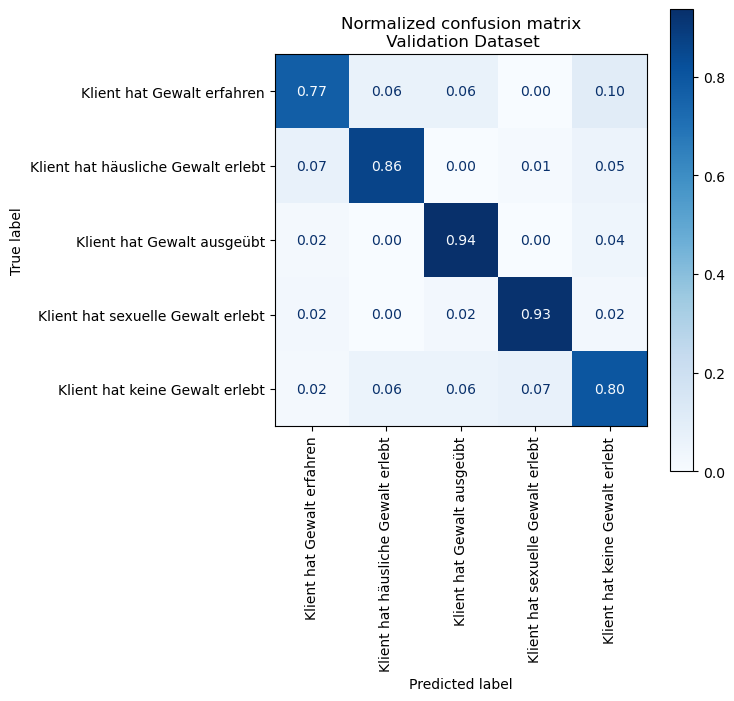

In [4]:


from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels, title2="Normalized confusion matrix", path='plot_confusion_matrix.png'):
    cm = confusion_matrix(y_true, y_preds , normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=True, xticks_rotation='vertical') 
    # plt.title("Normalized confusion matrix")
    plt.title(title2)
    plt.grid(False)
    plt.show()
    # plt.savefig(path)


eval_dataloader = DataLoader(
    tokenized_datasets["valid"], batch_size=1, collate_fn=data_collator
)


#mode mocel to gpu
model.to(device)

model.eval()
predictions_sum=[]
import evaluate

metric = evaluate.load("accuracy")
model.eval()
for batch in eval_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        preds, logits = model(**batch)
    # print(outputs.shape)    
    #create logits but AttributeError: 'tuple' object has no attribute 'logits'
    # logits = outputs[][]
    
    
    
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch["labels"])

#print accuracy score
print(metric.compute())

for batch in eval_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        #generate outputs
        preds, logits = model(**batch)
        

    #create logits
    # logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    predictions_sum+=predictions
    # print(logits)
    # print(predictions)
    # predictions.add_batch(predictions=predictions, references=batch["labels"])
    
    # precision_metric.add_batch(predictions=predictions, references=batch["labels"])

# hide_output
# preds_output = model.predict(tokenized_datasets["valid"])
# preds_output.metrics





predictions_sum = torch.Tensor(predictions_sum)
predictions_sum.cpu()
# len(predictions_sum)
plot_confusion_matrix(predictions_sum, tokenized_datasets["valid"]["labels"], gewalt_string, title2="Normalized confusion matrix\n Validation Dataset", path='validation_plot_confusion_matrix.png')



0 ROC AUC OvR: 0.9522
1 ROC AUC OvR: 0.9798
2 ROC AUC OvR: 0.9828
3 ROC AUC OvR: 0.9866
4 ROC AUC OvR: 0.9387
average ROC AUC OvR: 0.9680


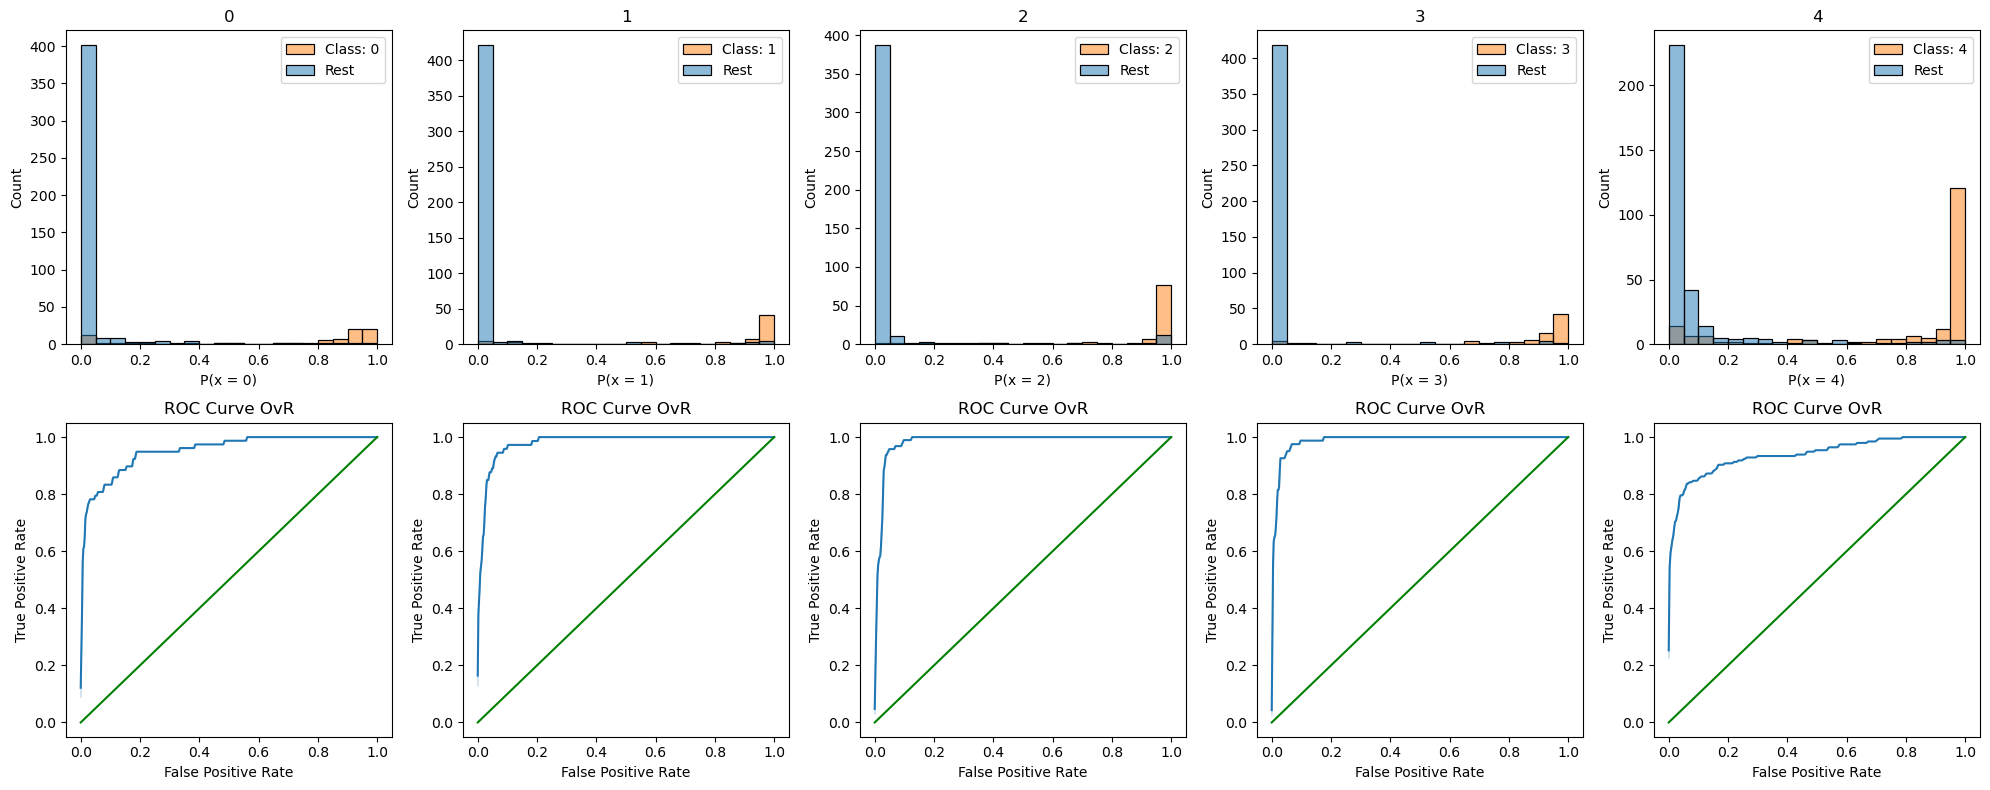

In [5]:




# # ROC One vs Rest Area under the Receiver Operating Charasteristic


roc_auc_score = evaluate.load("roc_auc", "multiclass")



from sklearn.metrics import roc_auc_score
# roc_auc_score(y, clf.predict_proba(X), multi_class='ovr')



# # ROC One vs Rest Area under the Receiver Operating Charasteristic
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.metrics import roc_auc_score


def calculate_tpr_fpr(y_real, y_pred):
    '''
    Calculates the True Positive Rate (tpr) and the True Negative Rate (fpr) based on real and predicted observations
    
    Args:
        y_real: The list or series with the real classes
        y_pred: The list or series with the predicted classes
        
    Returns:
        tpr: The True Positive Rate of the classifier
        fpr: The False Positive Rate of the classifier
    '''
    
    # Calculates the confusion matrix and recover each element
    cm = confusion_matrix(y_real, y_pred)
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    TP = cm[1, 1]
    
    # Calculates tpr and fpr
    tpr =  TP/(TP + FN) # sensitivity - true positive rate
    fpr = 1 - TN/(TN+FP) # 1-specificity - false positive rate
    
    return tpr, fpr

def get_all_roc_coordinates(y_real, y_proba):
    '''
    Calculates all the ROC Curve coordinates (tpr and fpr) by considering each point as a threshold for the predicion of the class.
    
    Args:
        y_real: The list or series with the real classes.
        y_proba: The array with the probabilities for each class, obtained by using the `.predict_proba()` method.
        
    Returns:
        tpr_list: The list of TPRs representing each threshold.
        fpr_list: The list of FPRs representing each threshold.
    '''
    tpr_list = [0]
    fpr_list = [0]
    for i in range(len(y_proba)):
        threshold = y_proba[i]
        y_pred = y_proba >= threshold
        tpr, fpr = calculate_tpr_fpr(y_real, y_pred)
        tpr_list.append(tpr)
        fpr_list.append(fpr)
    return tpr_list, fpr_list

def plot_roc_curve(tpr, fpr, scatter = True, ax = None):
    '''
    Plots the ROC Curve by using the list of coordinates (tpr and fpr).
    
    Args:
        tpr: The list of TPRs representing each coordinate.
        fpr: The list of FPRs representing each coordinate.
        scatter: When True, the points used on the calculation will be plotted with the line (default = True).
    '''
    if ax == None:
        plt.figure(figsize = (5, 5))
        ax = plt.axes()
    
    if scatter:
        sns.scatterplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = [0, 1], y = [0, 1], color = 'green', ax = ax)
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")



classes = np.array([0,1,2,3,4])
# classes



model.eval()
predictions_sum=[]
logits_sum=[]
probabilities_sum=[]
for batch in eval_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        preds, logits = model(**batch)
    # print(outputs)
    # logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    # props=nn.functional.softmax(logits, dim=-1)
    probabilities = nn.functional.softmax(logits, dim=-1)
    predictions_sum+=predictions
    logits_sum +=logits
    probabilities_sum += probabilities
    
predictions_sum = torch.Tensor(predictions_sum)
predictions_sum = predictions_sum.cpu()

# logits_sum
probabilities_sum = torch.stack(probabilities_sum)
probabilities_sum = probabilities_sum.cpu()

y_pred = predictions_sum
y_proba = probabilities_sum
y_valid = pd.Series(tokenized_datasets["valid"]["labels"])
X_valid = pd.DataFrame(tokenized_datasets["valid"]["labels"])



# Plots the Probability Distributions and the ROC Curves One vs Rest
plt.figure(figsize = (20, 8))
bins = [i/20 for i in range(20)] + [1]
roc_auc_ovr = {}

for i in range(len(classes)):
    # Gets the class
    c = classes[i]
    
    # Prepares an auxiliar dataframe to help with the plots
    df_aux = X_valid.copy()
    # print(c)
    df_aux['class'] = [1 if y == c else 0 for y in y_valid]
    df_aux['prob'] = y_proba[:, i]
    df_aux = df_aux.reset_index(drop = True)
    
    # Plots the probability distribution for the class and the rest
    ax = plt.subplot(2, 5, i+1)
    sns.histplot(x = "prob", data = df_aux, hue = 'class', color = 'b', ax = ax, bins = bins)
    ax.set_title(c)
    ax.legend([f"Class: {c}", "Rest"])
    ax.set_xlabel(f"P(x = {c})")
    
    # Calculates the ROC Coordinates and plots the ROC Curves
    ax_bottom = plt.subplot(2, 5, i+6)
    tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])
    plot_roc_curve(tpr, fpr, scatter = False, ax = ax_bottom)
    ax_bottom.set_title("ROC Curve OvR")
    
    # Calculates the ROC AUC OvR
    roc_auc_ovr[c] = roc_auc_score(df_aux['class'], df_aux['prob'])
    
plt.tight_layout()
# plt.savefig('roc_valid.png')

# Displays the ROC AUC for each class
avg_roc_auc = 0
i = 0
for k in roc_auc_ovr:
    avg_roc_auc += roc_auc_ovr[k]
    i += 1
    print(f"{k} ROC AUC OvR: {roc_auc_ovr[k]:.4f}")
print(f"average ROC AUC OvR: {avg_roc_auc/i:.4f}")



In [6]:


from sklearn.metrics import classification_report
my_tags = gewalt_string
print(classification_report(y_valid, y_pred,target_names=my_tags))




                                    precision    recall  f1-score   support

        Klient hat Gewalt erfahren       0.83      0.77      0.80        78
Klient hat häusliche Gewalt erlebt       0.80      0.86      0.83        73
        Klient hat Gewalt ausgeübt       0.83      0.94      0.88        95
 Klient hat sexuelle Gewalt erlebt       0.83      0.93      0.88        81
    Klient hat keine Gewalt erlebt       0.90      0.80      0.85       196

                          accuracy                           0.85       523
                         macro avg       0.84      0.86      0.85       523
                      weighted avg       0.85      0.85      0.85       523

